In [4]:
import sys
sys.path.append('../')
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

In [5]:
from mycode.utils import classes_def, clean_tweets

## Load Data

In [6]:
file_csv = "../dataset/Corona_NLP_train.csv"
dataset = pd.read_csv(file_csv,encoding="latin")

## Pipeline

### Define output classes

In [7]:
dataset['class'] = dataset['Sentiment'].apply(lambda x:classes_def(x))
dataset["class"].value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: class, dtype: float64

In [8]:
dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,class
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


### Text Cleaning

In [9]:
#!pip3 install bs4
#!pip3 install html5lib
#!pip3 install lxml

In [10]:
preprocessed_tweets = clean_tweets(dataset['OriginalTweet'].values)

100%|██████████| 41157/41157 [00:17<00:00, 2342.85it/s]


### Converting Text to Numerical Vector

In [11]:
tf_idf_vect = TfidfVectorizer(min_df=10)
tf_idf_vect.fit(preprocessed_tweets)
final_tf_idf = tf_idf_vect.transform(preprocessed_tweets)
print("The shape of out text TFIDF vectorizer: ",final_tf_idf.get_shape())

The shape of out text TFIDF vectorizer:  (41157, 6611)


### Select Atrubuttes

In [12]:
X = final_tf_idf.toarray()  # OriginalTweet
y = np.array(dataset["class"].tolist())

### Train and Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3,stratify=y,  random_state=42)

## Stacking

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

In [15]:
# get a stacking ensemble of models
def get_stacking(n_splits=5):
    # define the base models
    level0 = list()
    level0.append(('mnb', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)))
    level0.append(('rfc', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)))
    level0.append(('sgdc', SGDClassifier(class_weight='balanced', penalty='l1')))

    # define meta learner model
    level1 = SGDClassifier(class_weight='balanced', penalty='l1')
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=n_splits)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['mnb'] = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
    models['rfc'] = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
    models['sgdc'] = SGDClassifier(class_weight='balanced', penalty='l1')
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model_train(model, X_, y_, n_splits=5):
    #predict_proba = cross_val_predict(model, X_, y_, cv=n_splits, n_jobs=-1, method='predict_proba')
    predict = cross_val_predict(model, X_, y_, cv=n_splits, n_jobs=-1)
    print(f'Training Data CV Score: {np.round(accuracy_score(y_, predict),4) * 100}%')
    return predict

def evaluate_model_test(model, X_tr, y_tr, X_te, y_te):
    # Fit model
    model.fit(X_tr, y_tr)
    # Make predictions
    y_pred = model.predict(X_te)
    print(f'Testing Data Accuracy Score: {np.round(accuracy_score(y_te, y_pred), 4) * 100}%')
    return y_pred
    

### Data Train

In [16]:
# get the models to evaluate
models = get_models()
results_train = list()
for name, model in models.items():
    print('='*50)
    print(name)
    print('-'*50)
    results_train = evaluate_model_train(model, X_train, y_train)

mnb
--------------------------------------------------
Training Data CV Score: 66.88%
rfc
--------------------------------------------------
Training Data CV Score: 68.17%
sgdc
--------------------------------------------------
Training Data CV Score: 76.94%
stacking
--------------------------------------------------
Training Data CV Score: 79.54%


### Data Test

In [17]:
# evaluate the models and store results
results, names, times = list(), list(), list()
for name, model in models.items():
    print('='*50)
    print(name)
    print('-'*50)
    start_time = time.time()
    predict = evaluate_model_test(model, X_train, y_train, X_test, y_test)
    results.append(predict)
    names.append(name)
    times.append(time.time() - start_time)
    

mnb
--------------------------------------------------
Testing Data Accuracy Score: 67.84%
rfc
--------------------------------------------------
Testing Data Accuracy Score: 68.89999999999999%
sgdc
--------------------------------------------------
Testing Data Accuracy Score: 76.97%
stacking
--------------------------------------------------
Testing Data Accuracy Score: 79.51%


## Metrics

In [18]:
def classification_report(y_actual, list_y_predict, target_names, names_models, times):
    for i in range(len(list_y_predict)):
        print('='*50)
        print(names_models[i], ': ', times[i], ' seconds.')
        print('-'*50)
        print(metrics.classification_report(y_actual, list_y_predict[i], 
                                    target_names= target_names))

def plot_save_confussionmatrix(y_actual, list_y_pred, names_models):
    for i in range(len(list_y_pred)):
        plt.clf()
        cm=confusion_matrix(y_actual, list_y_pred[i])
        cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
        print("Accuracy:",names_models[i], accuracy_score(y_actual, list_y_pred[i]))

        sns.set(font_scale=1.,color_codes=True,palette="deep")
        sns.heatmap(cm_df,annot=True,annot_kws={"size":12},fmt="d",cmap="YlGnBu")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Value")
        plt.ylabel("True Value")
        plt.savefig('../dataset/images_result/'+ names_models[i] + '.png', format='png', dpi=120)

In [24]:
classification_report(y_test, results, dataset['class'].unique(), names, times)

mnb :  1.795240879058838  seconds.
--------------------------------------------------
              precision    recall  f1-score   support

           1       0.69      0.71      0.70      4620
           2       0.71      0.27      0.39      2314
           0       0.66      0.82      0.73      5414

    accuracy                           0.68     12348
   macro avg       0.69      0.60      0.61     12348
weighted avg       0.68      0.68      0.66     12348

rfc :  599.467159986496  seconds.
--------------------------------------------------
              precision    recall  f1-score   support

           1       0.75      0.64      0.69      4620
           2       0.49      0.79      0.61      2314
           0       0.79      0.69      0.74      5414

    accuracy                           0.69     12348
   macro avg       0.68      0.71      0.68     12348
weighted avg       0.72      0.69      0.69     12348

sgdc :  63.48714590072632  seconds.
-------------------------------

Accuracy: mnb 0.6784094590217039
Accuracy: rfc 0.6890184645286687
Accuracy: sgdc 0.7696793002915452
Accuracy: stacking 0.7951085195983155


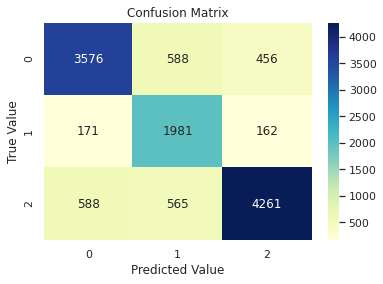

In [20]:
plot_save_confussionmatrix(y_test, results, names)